# Traffic Prediction & Signal Timing Reducing

Traffic is one of those annoying problems that affect many of us living in urban settings. One of the causes of traffic is the increase in urban populations. While the infrastructure is old and can only accommodate a limited population there is an influx of residents in search of livelihood and opportunities.

Traffic congestions lead to an increased in the combustion of fuel. It further increases the carbon emissions causing air pollution. It also costs time and money. INRIX's, a transportation analytics and connected car services, 2020 report found that on average, Americans lost 99 hours a year due to congestion, costing them nearly 88 billion dollars in 2019, an average of 1,377 dollars per year. From 2017 to 2019 the average time lost by American drivers has increased by two hours as economic and urban growth continues. link

In this project, I will be exploring the dataset of four junctions and built a model to predict traffic on the same. This could potentially help in solving the traffic congestion problem by providing a better understanding of traffic patterns that will further help in building an infrastructure to eliminate the problem.

# Table Of Contents

# 1.  Importing Libraries
# 2.  Loading Data
# 3.  Data Exploration
# 4.  Feature Engineering
# 5.  Exploratory Data Analysis  
# 6.  Data Transformation And Preprocessing
# 7.  Model Building
# 8.  Fitting The Model
# 9.  Inversing The Transformation Of Data
#10.  THE END







In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Loading Data
data = pd.read_csv("/content/traffic.csv")
data.head(5)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
data.tail(5)

,DateTime,Junction,Vehicles,ID
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224
48119,2017-06-30 23:00:00,4,12,20170630234


About the data

This dataset is a collection of numbers of vehicles at four junctions at an hourly frequency. The CSV file provides four features:

1-DateTime

2-Junctions

3-Vehicles

4-ID
## The sensors on each of these junctions were collecting data at different times, hence the traffic data from different time periods. Some of the junctions have provided limited or sparse data.

##               Data Exploration

1-Pharsing dates

2-Ploting timeseris

3-Feature engineering for EDA

In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

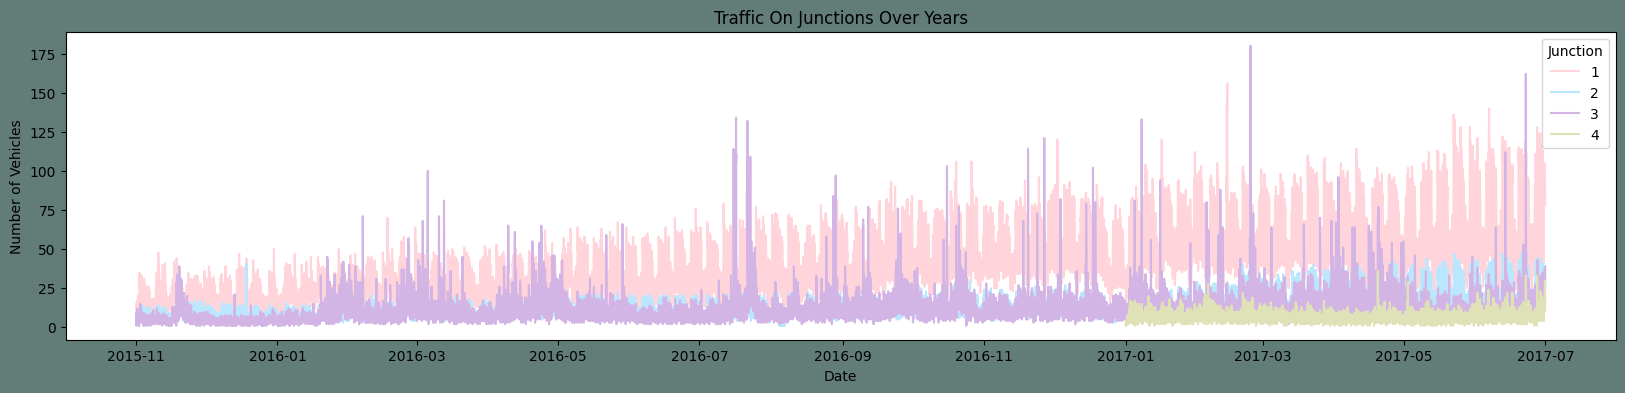

In [ ]:
#df to be used for EDA
df=data.copy()
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

Noticeable information in the above plot:

It can be seen here that the first junction is visibly having an upward trend.

The data for the fourth junction is sparse starting only after 2017

Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it.



# Feature Engineering
At this step, I am creating a few new features out of DateTime. Namely:

Year

Month

Date in the given month

Days of week

Hour

In [ ]:
#Exploring more features
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


# Exploratory Data Analysis


Plotting the newly created features

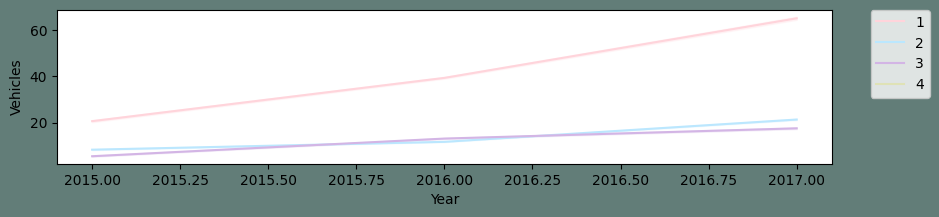

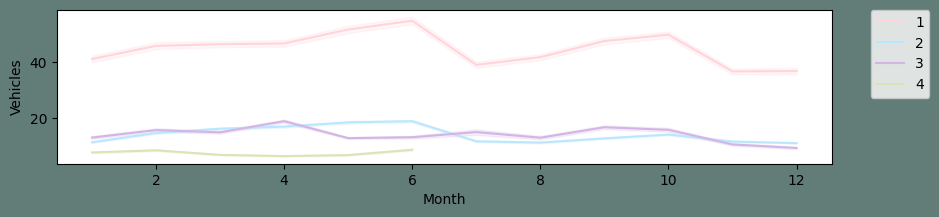

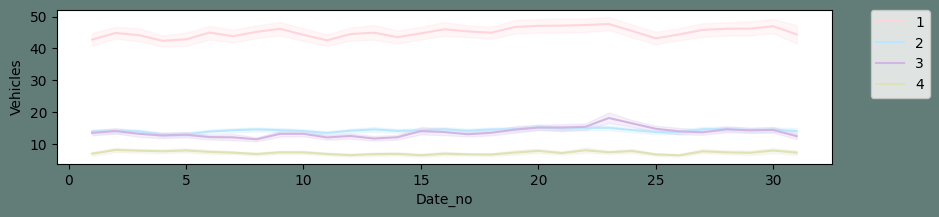

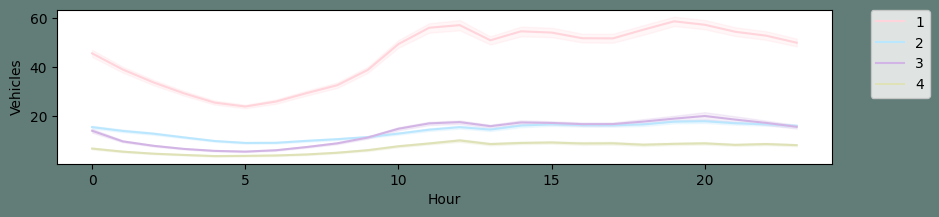

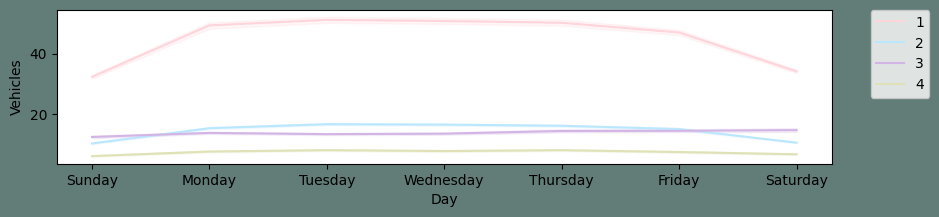

In [ ]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

From the above plot following things can be concluded:

Yearly, there has been an upward trend for all junctions except for the fourth junction. As we already established above that the fourth junction has limited data and that don't span over a year.

We can see that there is an influx in the first and second junctions around June. I presume this may be due to summer break and activities around the same.

Monthly, throughout all the dates there is a good consistency in data.

For a day, we can see that are peaks during morning and evening times and a decline during night hours. This is as per expectation.

For weekly patterns, Sundays enjoy smoother traffic as there are lesser vehicles on roads. Whereas Monday to Friday the traffic is steady.

Text(0.5, 0, 'Date')

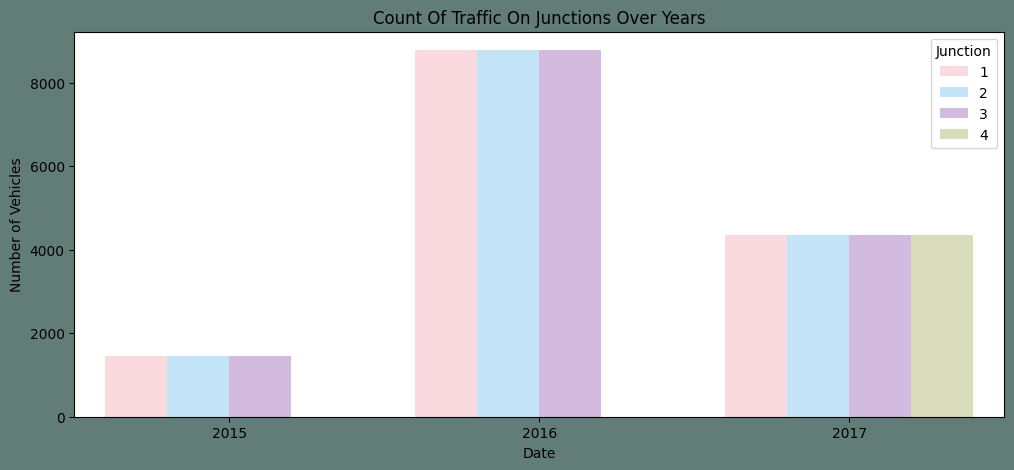

In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

The count plot shows that there is an increase in the number of vehicles between 2015 and 2016. However, it is inconclusive to say the same about 2017 as we have limited data for 2017 ie till the 7th month.

<Axes: >

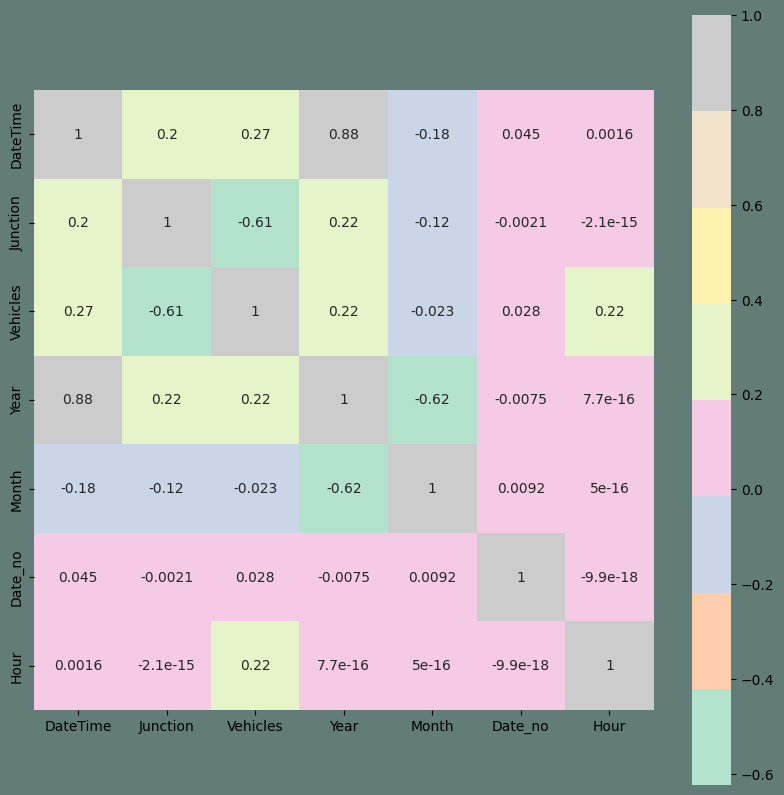

In [ ]:
# Calculate the correlation matrix, excluding non-numeric columns
# We can drop the 'Day' column which is of string type and causes the error.
corrmat = df.drop('Day', axis=1).corr()

plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True)

The highest correlation is certainly with the preexisting feature.

I will conclude my EDA with a pair plot. It's an interesting overall representation of any data.

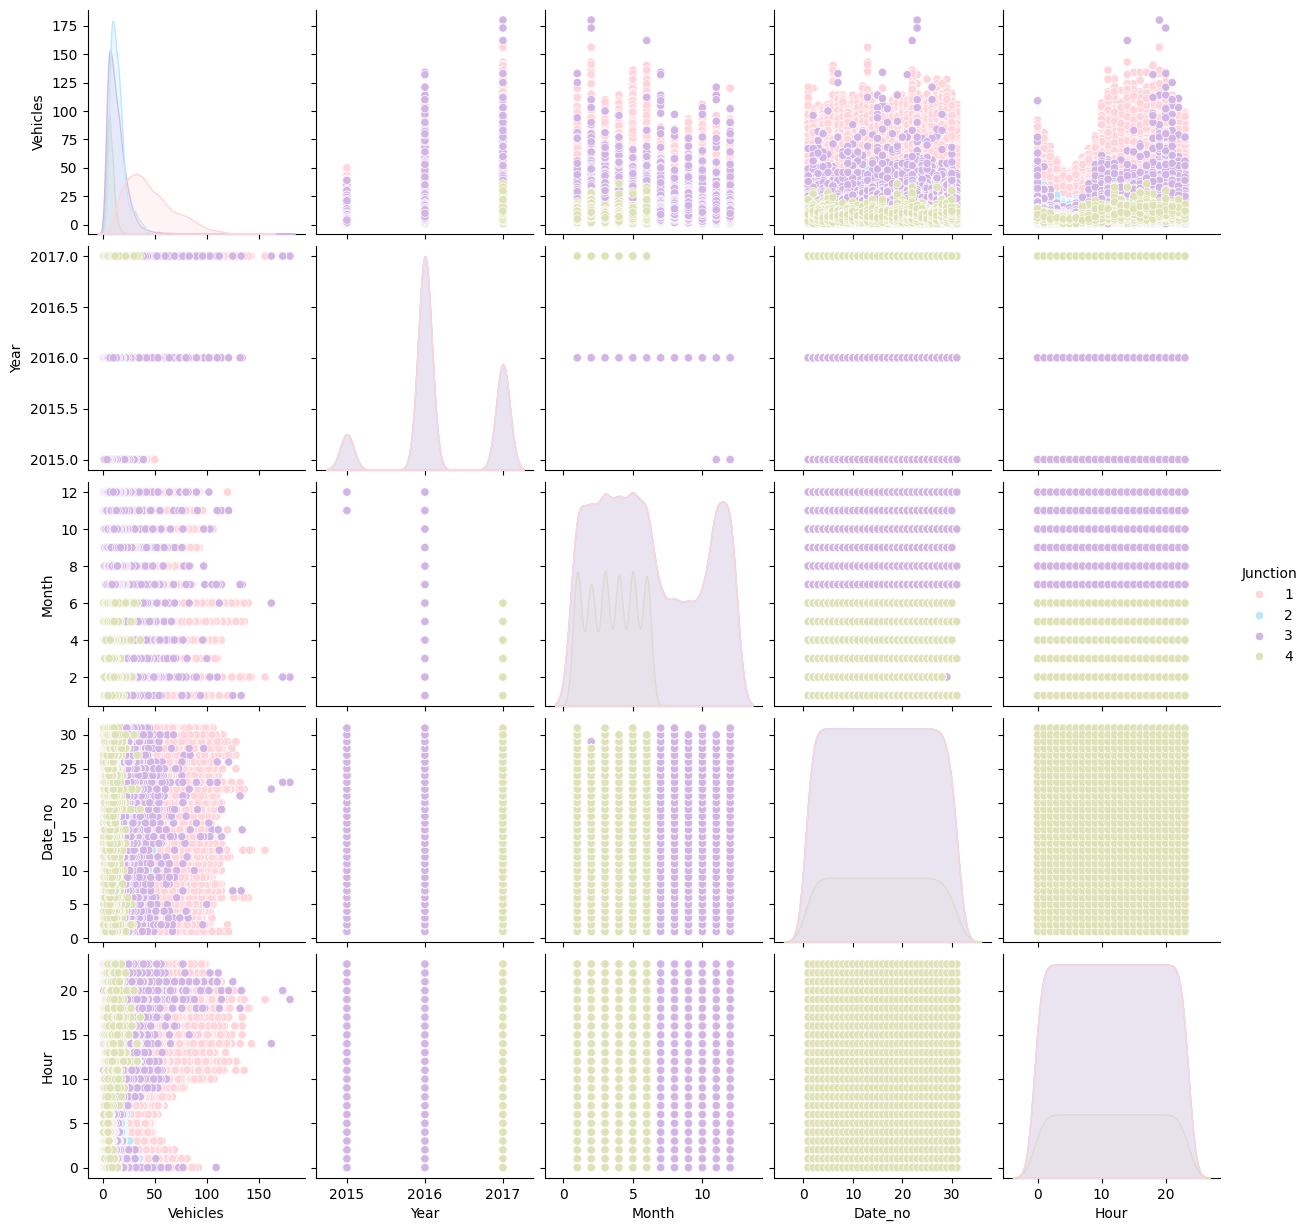

In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

Conclusions that I have come to draw after this EDA

The span of data from all four junctions is not the same. Data provided for the fourth junction is limited to only 2017.
The yearly trend for Junctions one, two and three have diffrent slopes.
Junction number one has a more strong weekly seasonality in comparison to the other junctions.
For the above-postulated reasons, I think that junctions must be transformed as per their individual needs.

Data Transformation And Preprocessing


In this step I will be following the subsequent order:

Creating different frames for each Junction and plotting them
Transforming the series and plotting them
Performing the Augmented Dickey-Fuller test to check the seasonality of transformed series
Creating test and train sets

In [ ]:
#Pivoting data fron junction
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

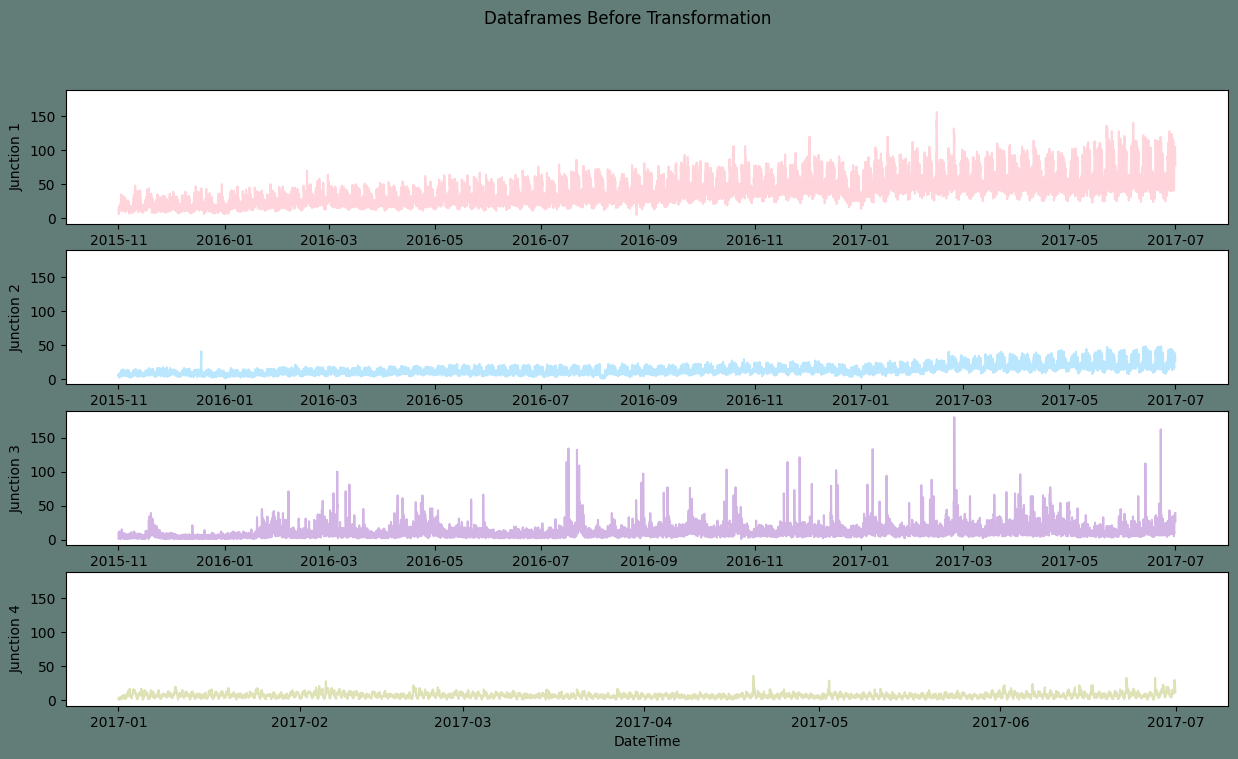

In [ ]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

A time series is stationary if it does not have a trend or seasonality. However, in the EDA, we saw a weekly seasonality and an upwards trend over the years. In the above plot, it is again established that Junctions one and two have an upward trend. If we limit the span we will be able to further see the weekly seasonality. I will be spairing that step at this point and moving on with the respective transforms on datasets.

Steps for Transforming:

Normalizing

Differencing

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In accordance with the above observations, Differencing to eliminate the seasonality should be performed as follows:

For Junction one, I will be taking a difference of weekly values.
For junction two, The difference of consecutive days is a better choice
For Junctions three and four, the difference of the hourly values will serve the purpose.

In [ ]:
#Normalizing and Differencing to make the series stationary
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4



#Plots of Transformed Dataframe

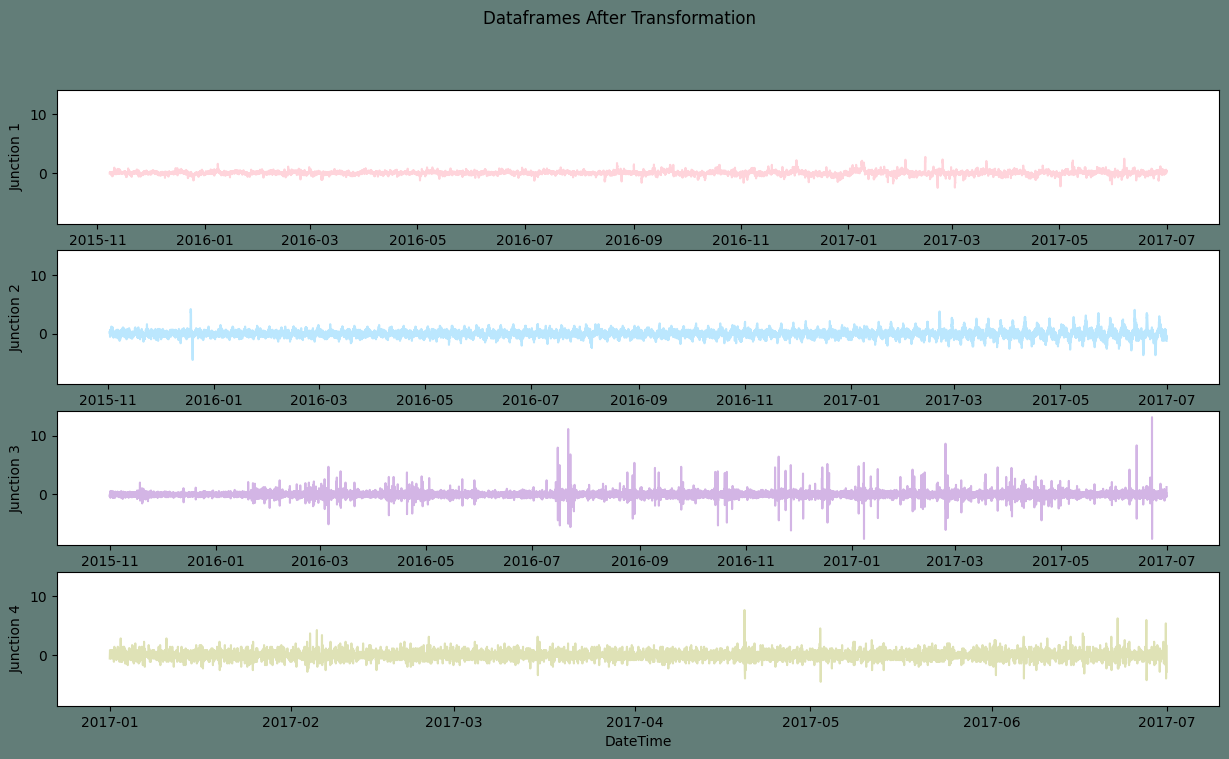

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")


he plots above seem linear. To ensure they are Stationary I will be performing an Augmented Dickey-Fuller test.

In [ ]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.26530339041543
p-value: 4.798539876396819e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.79589102694008
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832607
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305226
p-value: 2.7787875325955e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


Now that the data is stationary, preprocessing the data for the neural net by:

Splitting the test train sets
Assigning X as features and y as target
Reshaping data for neural net

In [ ]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

For this project, I have settled to use Gated Recurrent Unit (GRU). In this section, I am creating a function for the neural net to call on and fit the data frames for all four junctions.

MODEL BUILDING

In [ ]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

Fitting The Model


Now, I will be fitting the transformed training sets of four junctions to the model created and compare them to the transformed test sets.

Fitting the first junction and plotting the predictions and testset

In [ ]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 406ms/step - loss: 0.0870
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - loss: 0.0661
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 392ms/step - loss: 0.0673
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 406ms/step - loss: 0.0607
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - loss: 0.0667
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 404ms/step - loss: 0.0607
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 35s 405ms/step - loss: 0.0591
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 35s 405ms/step - loss: 0.0596
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - loss: 0.0609
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 402ms/step - loss: 0.0557
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 390ms/step - loss: 0.0565
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 405ms/step - loss: 0.0546
Epoch 13/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - loss: 0.0544
Epoch 14/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - loss: 0.0546
Epoch 15/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 

The root mean squared error is 0.24645514782562356.


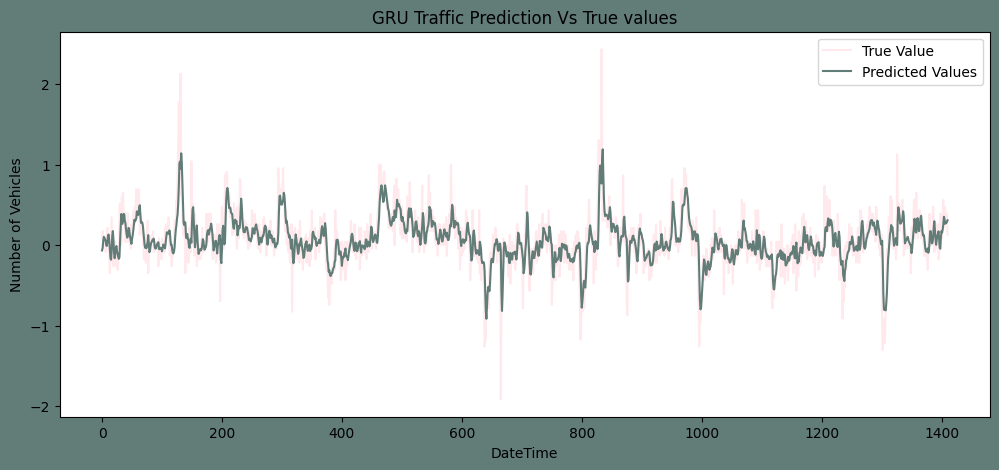

In [ ]:
 #Results for J1
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

Fitting the second junction and plotting the predictions and testset

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 389ms/step - loss: 0.2491
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 404ms/step - loss: 0.2091
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 422ms/step - loss: 0.1990
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 393ms/step - loss: 0.1994
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 393ms/step - loss: 0.1897
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 405ms/step - loss: 0.1934
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - loss: 0.1927
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 392ms/step - loss: 0.2005
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 405ms/step - loss: 0.1893
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 404ms/step - loss: 0.1843
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - loss: 0.1877
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 390ms/step - loss: 0.1905
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 400ms/step - loss: 0.1864
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 385ms/step - loss: 0.1830
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 

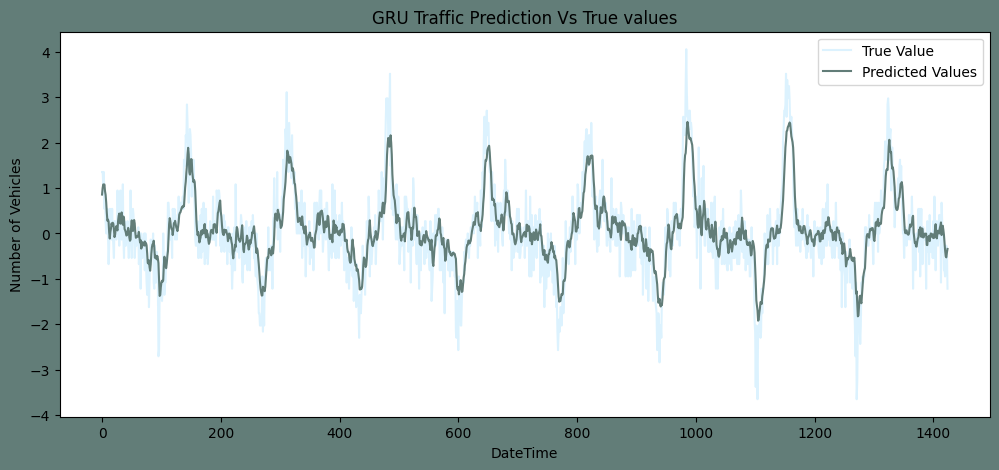

In [ ]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

Fitting the third junction and plotting the predictions and testset

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 45s 405ms/step - loss: 0.2881
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 392ms/step - loss: 0.3074
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 407ms/step - loss: 0.3022
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 405ms/step - loss: 0.2671
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 402ms/step - loss: 0.2722
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - loss: 0.2723
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - loss: 0.3039
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - loss: 0.2900
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 404ms/step - loss: 0.2877
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 403ms/step - loss: 0.2998
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - loss: 0.2987
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 408ms/step - loss: 0.2507
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 406ms/step - loss: 0.2994
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 394ms/step - loss: 0.2949
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 

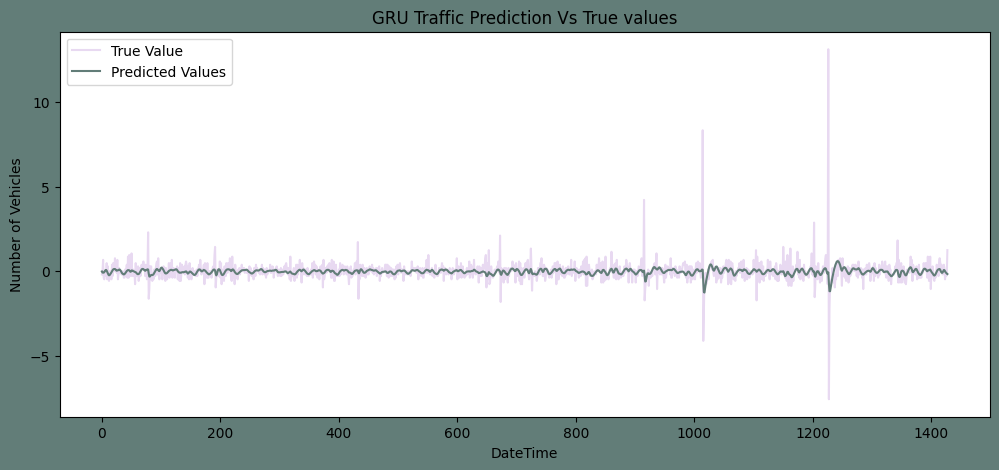

In [ ]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3)
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

Fitting the fourth junction and plotting the predictions and testset

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 359ms/step - loss: 0.6941
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - loss: 0.6599
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 410ms/step - loss: 0.7238
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - loss: 0.7004
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 408ms/step - loss: 0.7143
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - loss: 0.6678
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - loss: 0.6717
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - loss: 0.6854
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - loss: 0.7166
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 362ms/step - loss: 0.6728
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - loss: 0.6735
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - loss: 0.6455
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 412ms/step - loss: 0.6776
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - loss: 0.6803
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 

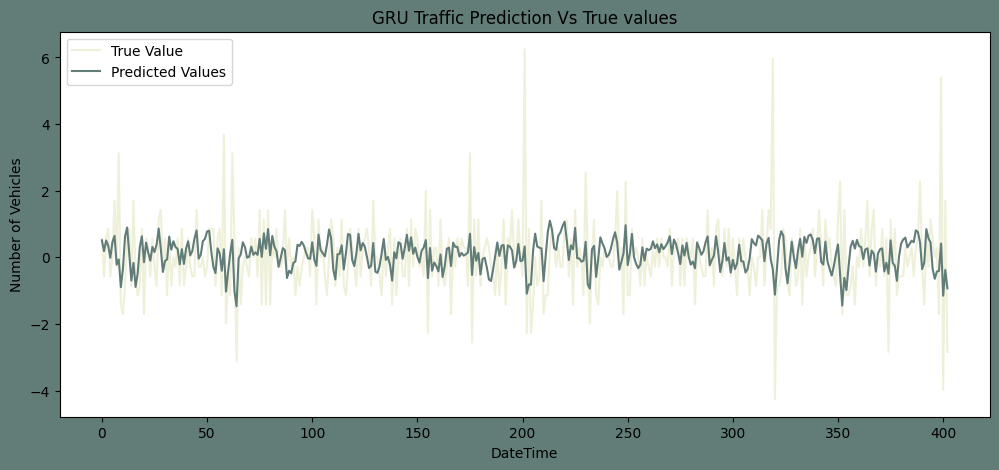

In [ ]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0508 - val_loss: 0.0115
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0081 - val_loss: 0.0095
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0069 - val_loss: 0.0082
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0061 - val_loss: 0.0074
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0059 - val_loss: 0.0071
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0058 - val_loss: 0.0090
Epoch 9/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0057 - val_loss: 0.0074
Epoch 10/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0058 - val_loss: 0.0070
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())


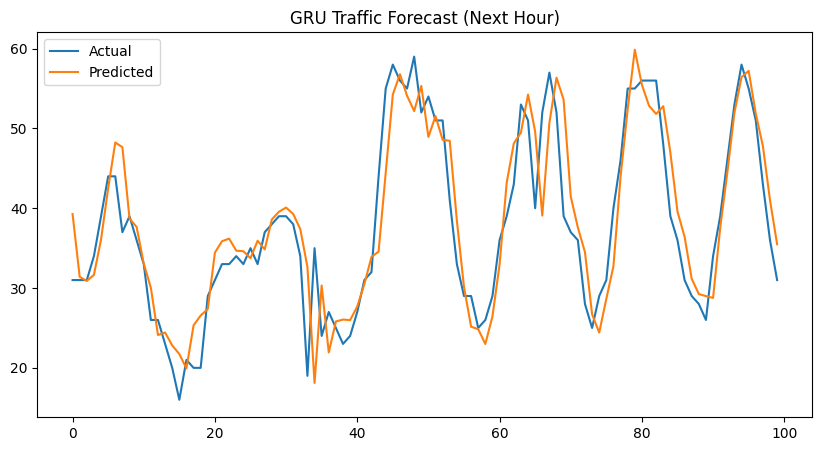

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


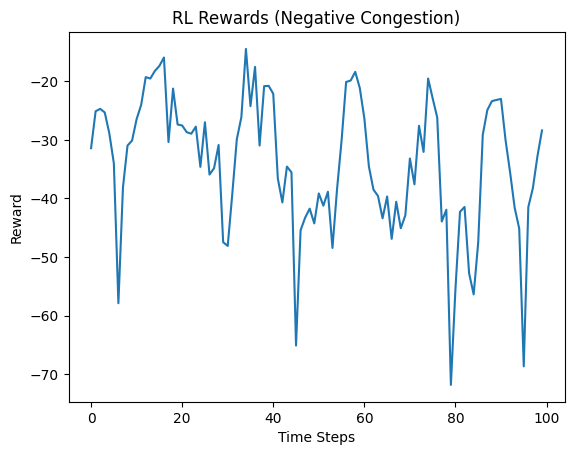

In [ ]:

# --- Step 1: Load & preprocess the data ---
df = pd.read_csv("cleaned_traffic.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df[df['Junction'] == 1].sort_values('DateTime')

scaler = MinMaxScaler()
vehicles_scaled = scaler.fit_transform(df[['Vehicles']])

# Create sequences for GRU
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 24
X, y = create_sequences(vehicles_scaled, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Step 2: Train GRU model ---
model = Sequential([
    GRU(64, input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer=Adam(0.001), loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# --- Step 3: Predict traffic using GRU ---
predictions = model.predict(X_test)
predicted_vehicles = scaler.inverse_transform(predictions)
actual_vehicles = scaler.inverse_transform(y_test)

# Plot predictions
plt.figure(figsize=(10,5))
plt.plot(actual_vehicles[:100], label='Actual')
plt.plot(predicted_vehicles[:100], label='Predicted')
plt.title('GRU Traffic Forecast (Next Hour)')
plt.legend()
plt.show()

# --- Step 4: RL Environment Setup ---
import gym
from gym import spaces
from stable_baselines3 import PPO

class TrafficEnv(gym.Env):
    def __init__(self, predictions):
        super(TrafficEnv, self).__init__()
        self.predictions = predictions.flatten()
        self.current_step = 0
        self.max_step = len(self.predictions) - 1

        # Action: [0, 1, 2] = short, medium, long signal duration
        self.action_space = spaces.Discrete(3)

        # Observation: predicted traffic level
        self.observation_space = spaces.Box(low=0, high=500, shape=(1,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return np.array([self.predictions[self.current_step]], dtype=np.float32)

    def step(self, action):
        traffic = self.predictions[self.current_step]

        # Simulate congestion: penalty increases with both traffic and poor signal choice
        duration_factor = [1.2, 1.0, 0.8][action]
        congestion = traffic * duration_factor

        reward = -congestion  # less congestion is better
        done = self.current_step >= self.max_step
        self.current_step += 1
        next_obs = np.array([self.predictions[min(self.current_step, self.max_step)]], dtype=np.float32)

        return next_obs, reward, done, {}

# --- Step 5: Train RL Agent ---
env = TrafficEnv(predicted_vehicles)
model_rl = PPO("MlpPolicy", env, verbose=0)
model_rl.learn(total_timesteps=10000)

# --- Step 6: Evaluate RL Agent ---
obs = env.reset()
rewards = []
for _ in range(100):
    action, _ = model_rl.predict(obs)
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        break

plt.plot(rewards)
plt.title("RL Rewards (Negative Congestion)")
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.show()
#df to be used for EDA
df=data.copy()
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44503 entries, 0 to 44502
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  44503 non-null  datetime64[ns]
 1   Junction  44503 non-null  int64         
 2   Vehicles  44503 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.0 MB


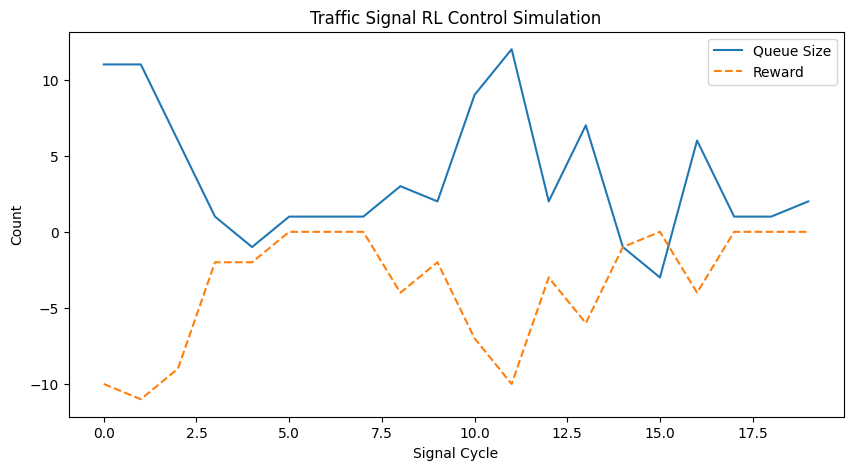

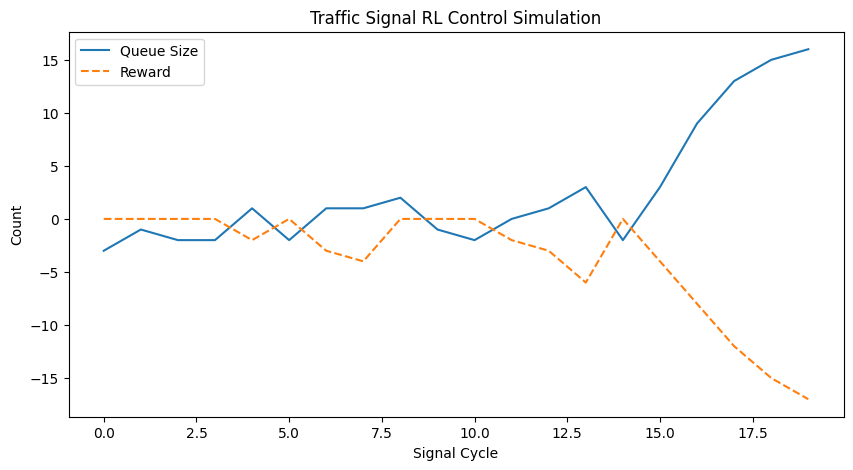

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Here's a Python implementation of a reinforcement learning (RL) agent for traffic signal control using a simple simulation. The agent determines the duration of the green signal based on predicted future vehicle counts using a GRU model.

import numpy as np
import matplotlib.pyplot as plt



class TrafficSignalEnv:
    def __init__(self):
        self.state = np.random.randint(5, 50)  # Predicted vehicle count
        self.queue = self.state  # Initial queue size

    def step(self, action):
        if action == "short":
            self.queue += np.random.randint(2, 8)  # Increase buildup
        elif action == "medium":
            self.queue += np.random.randint(-5, 5)  # Small fluctuation
        else:  # Long green signal
            self.queue -= np.random.randint(5, 10)  # Reduce queue

        self.queue = max(0, self.queue)  # No negative queue size
        reward = -self.queue
        self.state = self.queue + np.random.randint(-3, 3)  # Update state
        return self.state, reward

env = TrafficSignalEnv()


actions = ["short", "medium", "long"]
queue_sizes = []
rewards = []

for i in range(20):  # Simulating 20 signal cycles
    action = np.random.choice(actions)  # Random action selection
    state, reward = env.step(action)
    queue_sizes.append(state)
    rewards.append(reward)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(queue_sizes, label="Queue Size")
plt.plot(rewards, label="Reward", linestyle="--")
plt.xlabel("Signal Cycle")
plt.ylabel("Count")
plt.legend()
plt.title("Traffic Signal RL Control Simulation")
plt.show()

actions = ["short", "medium", "long"]
queue_sizes = []
rewards = []

for i in range(20):  # Simulating 20 signal cycles
    action = np.random.choice(actions)  # Random action selection
    state, reward = env.step(action)
    queue_sizes.append(state)
    rewards.append(reward)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(queue_sizes, label="Queue Size")
plt.plot(rewards, label="Reward", linestyle="--")
plt.xlabel("Signal Cycle")
plt.ylabel("Count")
plt.legend()
plt.title("Traffic Signal RL Control Simulation")
plt.show()



In [ ]:
nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn

Training the agent...
Training finished.
Simulating 20 cycles with random actions...
Simulation finished.


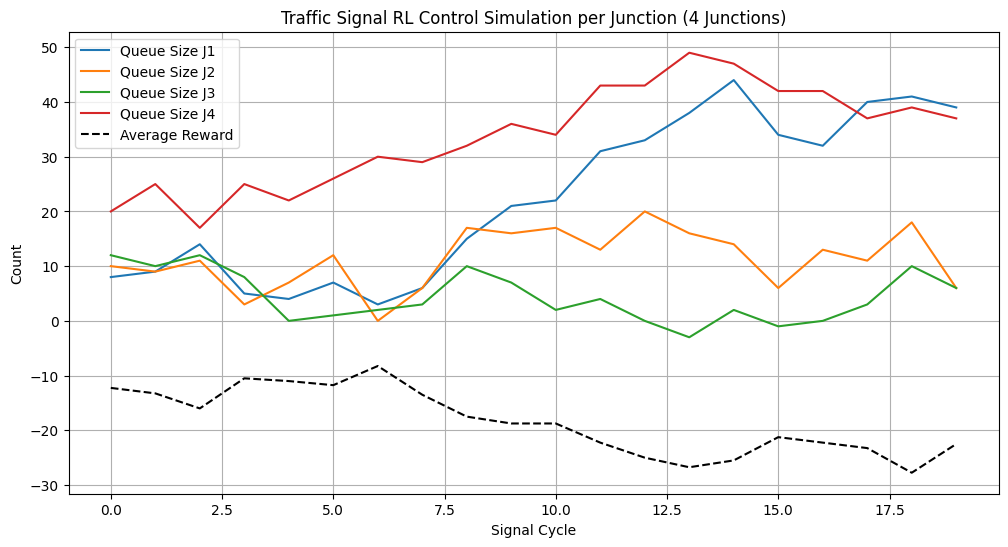

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from collections import deque

# %%
class TrafficEnv:
    def __init__(self, junctions=4): # Changed default to 4 junctions
        self.junctions = junctions
        # Initialize state and queue for the specified number of junctions
        self.state = np.random.randint(10, 50, size=(junctions,))
        self.queue = self.state.copy()

    def step(self, action):
        new_state = []
        reward_per_junction = [] # Collect individual junction rewards
        for i in range(self.junctions):
            # Ensure action index is within bounds (should be 0, 1, or 2)
            # The previous code used string actions ("short", "medium", "long").
            # If the action is expected to be a list of strings, this needs adjustment.
            # If the action is expected to be a list of integers (0, 1, 2), the logic below works.
            # Let's assume action is a list of integers [0, 1, 2] for each junction.
            # The previous random action selection was [random.choice(["short", "medium", "long"]) for _ in range(self.junctions)]
            # which produces strings. The step method was written to handle strings.
            # Let's keep the action as a list of strings as per the original code structure.
            current_action = action[i]

            if current_action == "short":
                self.queue[i] += np.random.randint(3, 8)
            elif current_action == "medium":
                self.queue[i] += np.random.randint(-5, 5)
            else:  # Long green signal
                self.queue[i] -= np.random.randint(5, 10)

            self.queue[i] = max(0, self.queue[i])
            new_state.append(self.queue[i] + np.random.randint(-3, 3))
            reward_per_junction.append(-self.queue[i])

        self.state = np.array(new_state)
        # Return the state and the list of rewards for each junction
        # Returning mean reward makes it simpler for a single output Dense layer.
        # If the DQN model is meant to predict a value per junction, the target needs to match.
        # Given the model output layer Dense(self.junctions), let's assume the target
        # should be the reward for each junction, or some other relevant per-junction value.
        # Since the previous code calculated mean reward, let's stick to returning mean.
        # The model's output shape and loss might need re-evaluation for a proper multi-junction DQN.
        # For now, returning mean and adjusting the training target based on mean.
        return self.state, np.mean(reward_per_junction)

# %%
class DQNAgent:
    def __init__(self, junctions):
        self.junctions = junctions
        self.memory = deque(maxlen=2000)
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            # Input shape reflects the number of junctions
            tf.keras.layers.Dense(24, activation="relu", input_shape=(self.junctions,)),
            tf.keras.layers.Dense(24, activation="relu"),
            # Output layer predicts a value for each junction
            tf.keras.layers.Dense(self.junctions, activation="linear")
        ])
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
        return model

    def train(self, env, episodes=1000):
        for _ in range(episodes):
            state = env.state
            # Random action selection for demonstration - replace with agent's policy
            action = [random.choice(["short", "medium", "long"]) for _ in range(self.junctions)]
            next_state, reward = env.step(action)
            self.memory.append((state, action, reward, next_state))

            x_train = np.array(state).reshape(-1, self.junctions)

            # Fix: Reshape the scalar mean reward to match the model's output shape (1, self.junctions)
            # This is a simplified target. A proper DQN would calculate Q-values using the Bellman equation.
            y_train = np.full((1, self.junctions), reward) # Replicate the mean reward for each junction

            self.model.fit(x_train, y_train, verbose=0)

# %%
# Create the environment and agent for 4 junctions
env = TrafficEnv(junctions=4)
agent = DQNAgent(junctions=4)

# Train the agent
print("Training the agent...")
agent.train(env, episodes=500)
print("Training finished.")

# Generate Simulation Results using random actions for demonstration
# In a real application, the agent's predicted action would be used here.
queue_sizes = []
rewards = []

print("Simulating 20 cycles with random actions...")
for i in range(20):
    # Random action for each of the 4 junctions
    action = [random.choice(["short", "medium", "long"]) for _ in range(4)]
    state, reward = env.step(action)
    queue_sizes.append(state)
    rewards.append(reward)
print("Simulation finished.")

# Visualization
plt.figure(figsize=(12, 6)) # Increased figure size for better readability
# Plot queue sizes for all junctions. Matplotlib will plot multiple lines if queue_sizes contains arrays.
plt.plot(np.array(queue_sizes), label=[f"Queue Size J{j+1}" for j in range(env.junctions)]) # Label each junction
plt.plot(rewards, label="Average Reward", linestyle="--", color='black') # Plot mean reward
plt.xlabel("Signal Cycle")
plt.ylabel("Count")
plt.legend()
plt.title("Traffic Signal RL Control Simulation per Junction (4 Junctions)")
plt.grid(True) # Add a grid
plt.show()

In [ ]:
 newwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the agent...
Episode 100/500 finished.
Episode 200/500 finished.
Episode 300/500 finished.
Episode 400/500 finished.
Episode 500/500 finished.
Training finished.
Simulating 100 cycles with the trained agent...
Simulation finished.


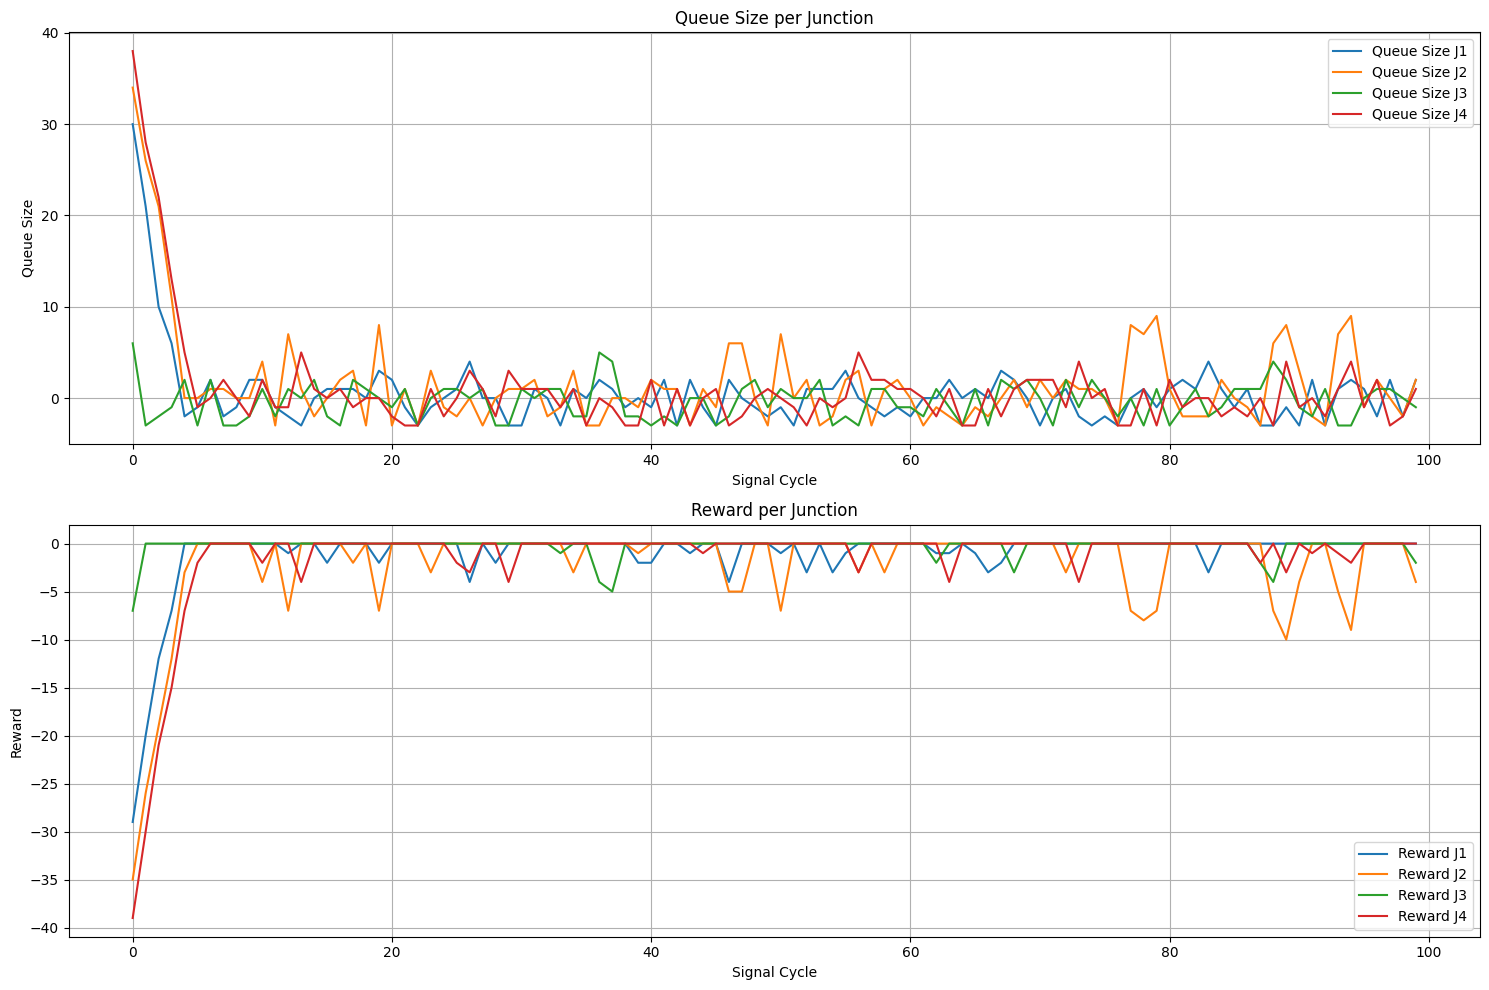

In [ ]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from collections import deque

class TrafficEnv:
    def __init__(self, junctions=4):
        self.junctions = junctions
        self.state = np.random.randint(10, 50, size=(junctions,))
        self.queue = self.state.copy()
        self.action_map = {0: "short", 1: "medium", 2: "long"} # Map integer actions to strings

    def step(self, actions): # actions is a list of integers [0, 1, 2]
        new_state = []
        reward_per_junction = []
        for i in range(self.junctions):
            current_action = self.action_map[actions[i]] # Get string action from integer

            if current_action == "short":
                self.queue[i] += np.random.randint(3, 8)
            elif current_action == "medium":
                self.queue[i] += np.random.randint(-5, 5)
            else:  # Long green signal
                self.queue[i] -= np.random.randint(5, 10)

            self.queue[i] = max(0, self.queue[i])
            new_state.append(self.queue[i] + np.random.randint(-3, 3))
            reward_per_junction.append(-self.queue[i])

        self.state = np.array(new_state)
        return self.state, np.mean(reward_per_junction), reward_per_junction # Return state, mean reward, and per-junction rewards

    # Add a reset method to initialize the environment for a new simulation run
    def reset(self):
        self.state = np.random.randint(10, 50, size=(self.junctions,))
        self.queue = self.state.copy()
        return self.state


class DQNAgent:
    def __init__(self, junctions):
        self.junctions = junctions
        self.memory = deque(maxlen=2000)
        self.action_space_size = 3 # short, medium, long
        self.model = self.build_model()


    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(24, activation="relu", input_shape=(self.junctions,)),
            tf.keras.layers.Dense(24, activation="relu"),
            tf.keras.layers.Dense(self.junctions * self.action_space_size, activation="linear") # Output for Q-values for each action per junction
        ])
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
        return model

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states = np.array([x[0] for x in minibatch])
        actions = np.array([x[1] for x in minibatch])
        rewards = np.array([x[2] for x in minibatch])
        next_states = np.array([x[3] for x in minibatch])

        # Reshape states and next_states for the model
        states = states.reshape(-1, self.junctions)
        next_states = next_states.reshape(-1, self.junctions)

        # Simple target (mean reward) - needs refinement for proper DQN
        # A more accurate target would involve next_state Q-values (Bellman equation)

        target_f = self.model.predict(states, verbose=0)

        # Update the target for the chosen action based on the reward
        # This part needs adjustment for the new output shape
        # The model predicts Q-values for each action for each junction.
        # The target for a specific junction and action should be updated.
        # For simplicity here, we'll use the mean reward to update all junction's Q-values for the taken action.
        # A proper DQN implementation would be more complex.
        for i in range(batch_size):
            for j in range(self.junctions):
                # Assuming actions is a list of integer actions [0, 1, 2]
                action_index = actions[i][j]
                target_f[i][j * self.action_space_size + action_index] = rewards[i] # Use the mean reward

        self.model.fit(states, target_f, epochs=1, verbose=0)

    def predict(self, state):
        # Reshape state for prediction
        state = state.reshape(-1, self.junctions)
        q_values = self.model.predict(state, verbose=0)[0] # Get Q-values for the current state

        # Select the best action for each junction
        actions = []
        for j in range(self.junctions):
            # Find the action with the highest Q-value for junction j
            junction_q_values = q_values[j * self.action_space_size : (j + 1) * self.action_space_size]
            best_action_index = np.argmax(junction_q_values)
            actions.append(best_action_index) # Store the integer action index

        return actions # Return a list of integer actions [0, 1, 2] for each junction


# Create the environment and agent for 4 junctions
env = TrafficEnv(junctions=4)
agent = DQNAgent(junctions=4)

# Train the agent
print("Training the agent...")
episodes = 500
for episode in range(episodes):
    state = env.state.copy()
    # Use random actions during initial training for exploration (can be replaced by epsilon-greedy)
    # Access action_space_size from the agent (self)
    action_indices = [random.choice(range(agent.action_space_size)) for _ in range(env.junctions)]
    next_state, mean_reward, per_junction_rewards = env.step(action_indices)
    agent.remember(state, action_indices, mean_reward, next_state)
    agent.train() # Train after each step
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{episodes} finished.")

print("Training finished.")

# Generate Simulation Results using the trained agent
simulation_cycles = 100
queue_sizes = [[] for _ in range(env.junctions)] # List of lists to store queue sizes per junction
mean_rewards = []
per_junction_rewards_hist = [[] for _ in range(env.junctions)] # Store per-junction rewards

print(f"Simulating {simulation_cycles} cycles with the trained agent...")
state = env.reset() # Reset the environment for simulation before simulation
for i in range(simulation_cycles):
    action_indices = agent.predict(state) # Get actions from the trained agent
    state, mean_reward, per_junction_rewards = env.step(action_indices) # Get next state and rewards

    # Store queue sizes and rewards
    for j in range(env.junctions):
        queue_sizes[j].append(state[j])
        per_junction_rewards_hist[j].append(per_junction_rewards[j])
    mean_rewards.append(mean_reward)

print("Simulation finished.")

# Visualization
plt.figure(figsize=(15, 10))

# Plot Queue Sizes per Junction
plt.subplot(2, 1, 1)
for j in range(env.junctions):
    plt.plot(queue_sizes[j], label=f"Queue Size J{j+1}")
plt.xlabel("Signal Cycle")
plt.ylabel("Queue Size")
plt.title("Queue Size per Junction")
plt.legend()
plt.grid(True)

# Plot Rewards per Junction
plt.subplot(2, 1, 2)
for j in range(env.junctions):
    plt.plot(per_junction_rewards_hist[j], label=f"Reward J{j+1}")
plt.xlabel("Signal Cycle")
plt.ylabel("Reward")
plt.title("Reward per Junction")
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

Training GRU for Junction 1


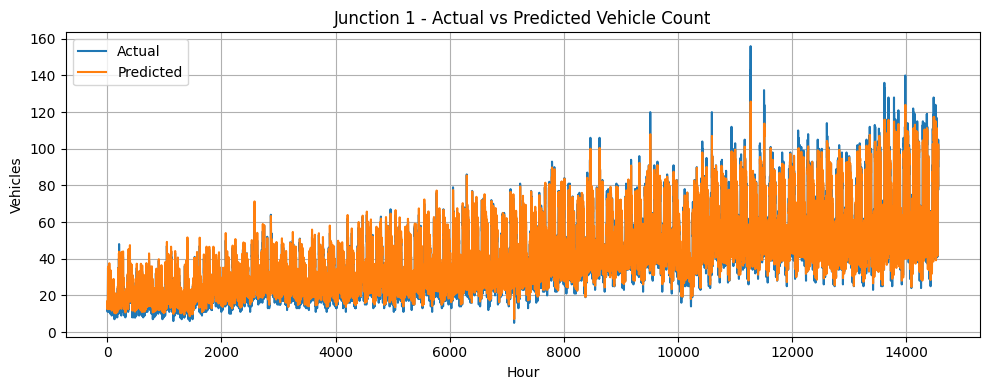

Training GRU for Junction 2


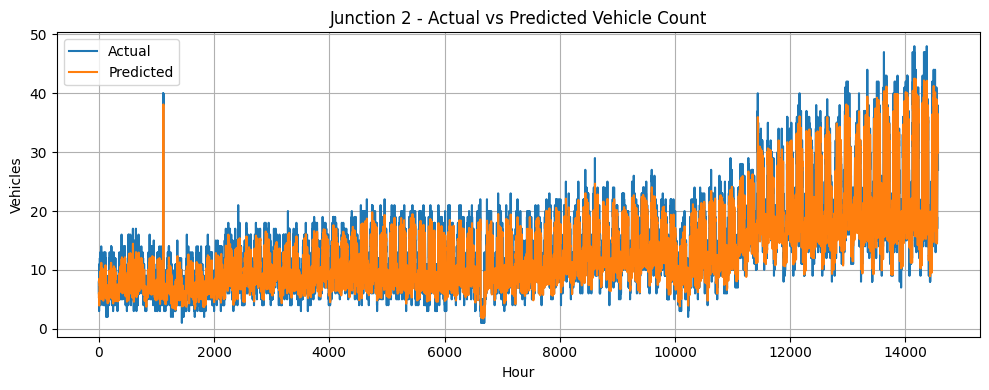

Training GRU for Junction 3


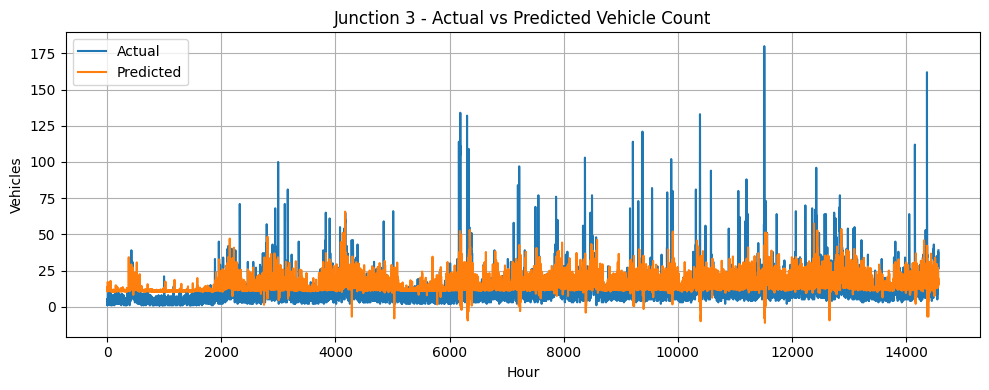

Training GRU for Junction 4


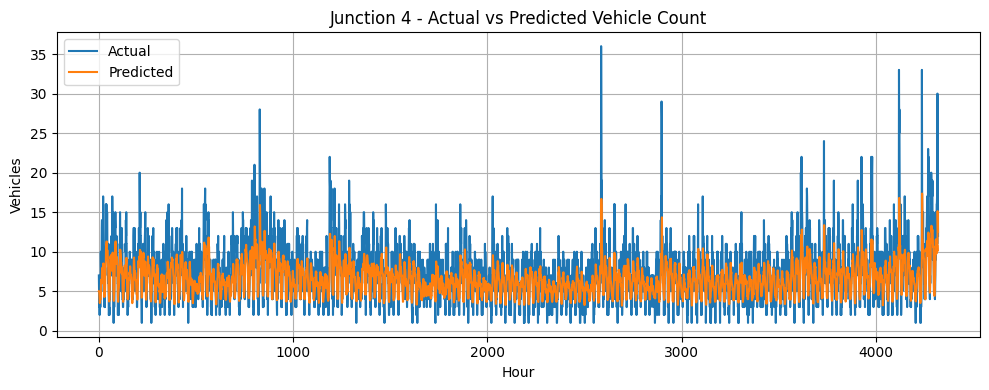

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# --------------------------
# GRU Model Definition
# --------------------------
class GRUNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, h = self.gru(x)
        out = self.fc(h[-1])
        return out

# --------------------------
# Prepare Sequence Data
# --------------------------
def create_sequences(data, seq_length=24):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# --------------------------
# Train and Predict per Junction
# --------------------------
# Train and Predict per Junction
# --------------------------
def train_and_predict(junction_id, data, epochs=30):
    print(f"Training GRU for Junction {junction_id}")
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[['Vehicles']])

    X, y = create_sequences(scaled_data, 24)
    # X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1) # Remove unsqueeze(-1)
    X = torch.tensor(X, dtype=torch.float32) # Corrected conversion
    y = torch.tensor(y, dtype=torch.float32)

    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = GRUNet()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for xb, yb in loader:
            pred = model(xb)
            loss = criterion(pred.squeeze(), yb.squeeze())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Prediction
    model.eval()
    with torch.no_grad():
        pred = model(X).squeeze().numpy()

    # Inverse transform for plotting
    true = scaler.inverse_transform(y.reshape(-1, 1)).flatten()
    predicted = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(true, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(f'Junction {junction_id} - Actual vs Predicted Vehicle Count')
    plt.xlabel('Hour')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --------------------------
# Main Workflow
# --------------------------
# Load data
df = pd.read_csv("traffic.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values(['Junction', 'DateTime'])

# Train separate models per junction
for junc in df['Junction'].unique():
    junc_data = df[df['Junction'] == junc].reset_index(drop=True)
    if len(junc_data) > 48:  # ensure enough data
        train_and_predict(junc, junc_data)